In [1]:
# Import the packages
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
from sklearn.metrics import r2_score
from sqlalchemy import create_engine


In [2]:
def bulk_insert(df, table_name, conn_string):
    conn = psycopg2.connect(conn_string)
    cur = conn.cursor()
    output = io.StringIO()
    df.to_csv(output, sep='\t', header=False, index=True)
    output.seek(0)
    cur.copy_from(output,table_name, null="")
    conn.commit()
    conn.close()


## tspDB Running Example
In this notebook, we showcase the core  functionalities of **tspDB** on a Real world dataset

In particular, we show:

**(1)**  How a prediction index is created on multiple time series

**(2)** How predictions are produced with uncertainity quantification, 

**(3)**  How does the predictions and confidence interval compare with the observations and their underlining means.


### To run this test, you need:

**(1)** tspDB installed on a PostgreSQL Database

**(2)** psycopg2, pandas, sqlalchemy and matplotlib packages installed




## Dataset

The dataset we will be using is a real world dataset available at the [UCI repository](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#). The dataset describes the 15-minutes load for 370 houses. We will aggregate the data into horly data and split it into a training set with  25968 time-points, and a test set that has 168 datapoints.  The forecasting task here is to perform rolling window hourly forecasting for the next 7 days by forecasting one day at a time. First we will download the data from the UCI repository. 

**NOTE:** The dataset size is ~ 250 MB, so it might take a while depending on your connection.


In [24]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
!unzip LD2011_2014.txt.zip
# change commas to dots
!sed 's/,/./g' LD2011_2014.txt > LD2011_2014_clean.txt

Let's now load and preprocess the data. Specifically we will:

1- Pick the first 20 houses `MT-001`to `MT-020`

1- Aggregate the data into hourly readings by avergaing the 15-minutes readings.

2- Remove the data before 2011, since most of its readings are zeros

In [25]:
data = pd.read_csv('LD2011_2014_clean.txt', delimiter = ';')
#remove data before 2012
data = data.iloc[8760*4:]
print('data loaded..')
data_2 = data.copy()
#pick the first 20 houses
data_2 = data_2.iloc[:,:21]
# Aggregate
data_2['time'] =pd.to_datetime(data_2['Unnamed: 0']).dt.ceil('1h') 
data_2 = data_2.drop(['Unnamed: 0'], axis = 1)
agg_dict = {}
for col in data_2.columns[:-1]:
    agg_dict[col] ='mean'
data_3 = data_2.groupby(['time']).agg(agg_dict)
print('data aggregated..')

data loaded..
data aggregated..


Now each column of the dataframe `data_3` contains hourly reading starting from `2012-01-01 01:00` until `2015-01-01 01:00`. In this experiment, as mentioned before, we will split the observations into a training and testing sets. Specifically, the training set will start at  `2012-01-01 01:00` until `2014-12-18 00:00`. and the test set will have the rest of the observations.




Splitting the data into training and testing sets:

In [26]:
data_train = data_3.iloc[:25968]
data_test = data_3.iloc[25968:]


First, we will upload the this dataset into your PostgreSQL database. To do so, we will first set up connection to the database.

## DB connection

**Here, you need to fill in your database connection information below**

In [27]:
## fill your db information
database = '' # FILL IN your db name where tspdb is installed
user = 'postgres' #  FILL IN  user name here
password = '00' #  # FILL IN  password here
host = 'localhost' #  # FILL IN  host name
conn_string = "host='%s' dbname='%s' user='%s' password='%s'" %(host, database, user, password)
driver="postgresql"
engine = create_engine(driver + '://' + user + ':' + password + '@' + host + '/' + database)

## Create Time Series Table
Now, we will load the dataset into your database. We will store it in table `electricity_20`

**Note:** Given the size of the data, this may take a while

In [28]:
conn = psycopg2.connect(conn_string)

cur = conn.cursor()

# Drop the table if it already exists
cur.execute("DROP table IF EXISTS electricity_20;")
conn.commit()
conn.close()
# load data into Pandas dataframe
data_train.to_sql('electricity_20', engine, index=True, index_label='time')
data_train.to_csv('ss.csv')
print('Table created and Loaded')



Table created and Loaded


Now the table is loaded into the database. Let's check the last 10 entries of the table

In [29]:
# lets query our table mixturets2 to inspect its column 
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from electricity_20 order by time DESC limit 10;", conn)
conn.close()
df

,time,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020
0,2014-12-18 00:00:00,2.220812,20.092461,1.737619,159.044715,89.329268,293.898810,6.500848,266.835017,55.944056,...,49.180328,148.404255,49.336650,45.628590,56.689050,42.141230,47.169811,279.552716,10.050251,54.185022
1,2014-12-17 23:00:00,2.538071,21.870555,1.737619,199.186992,99.085366,334.077381,6.783493,316.498316,70.367133,...,55.886736,157.446809,46.227197,52.169751,65.599174,50.398633,61.994609,348.242812,11.055276,64.977974
2,2014-12-17 22:00:00,2.538071,23.648649,1.737619,198.678862,94.512195,362.351190,6.500848,362.794613,72.115385,...,58.867362,164.893617,57.628524,56.796426,67.794421,56.520501,73.000898,416.932907,13.316583,71.585903
3,2014-12-17 21:00:00,2.220812,25.604552,1.737619,233.231707,97.560976,412.946429,7.207462,420.033670,93.094406,...,70.603577,176.063830,78.772803,54.403318,72.701446,59.225513,70.979335,442.492013,14.321608,66.519824
4,2014-12-17 20:00:00,2.220812,26.315789,1.737619,232.723577,105.182927,476.934524,7.348785,412.457912,102.709790,...,75.074516,206.382979,97.222222,65.730696,80.836777,52.676538,78.840970,466.453674,17.336683,67.841410
5,2014-12-17 19:00:00,2.220812,24.359886,2.172024,209.349593,106.707317,398.065476,6.500848,395.622896,89.597902,...,71.907601,198.404255,112.976783,70.516911,84.065083,45.985194,77.717880,416.134185,14.447236,66.960352
6,2014-12-17 18:00:00,2.538071,23.293030,2.606429,148.373984,91.158537,258.928571,5.370266,352.693603,66.433566,...,46.758569,207.446809,136.401327,73.388641,79.674587,38.012528,68.733154,394.568690,10.050251,58.149780
7,2014-12-17 17:00:00,2.855330,22.581792,1.737619,104.166667,67.073171,199.404762,3.674392,293.771044,44.580420,...,32.600596,180.851064,133.913765,63.975750,68.310950,26.195900,52.111411,293.929712,7.035176,45.594714
8,2014-12-17 16:00:00,4.124365,23.470839,1.520417,101.626016,66.158537,180.059524,3.815715,275.252525,43.269231,...,38.748137,164.893617,142.827529,69.240587,65.470041,24.060364,48.966757,280.351438,8.040201,40.308370
9,2014-12-17 15:00:00,1.903553,23.826458,1.520417,99.593496,60.060976,197.916667,3.391747,287.878788,44.580420,...,38.002981,154.787234,156.509121,70.835992,69.860537,23.917995,51.886792,301.118211,5.904523,41.409692


Now, using **tspDB**, we will be able to forecast *future values*! To do that, we must first create a **prediction index**,and that's what we would do next


## Create prediction index


Now, we will create a predictive index which we will call `pindex_e20` on all data column [`MT_001`, `MT_002`,`MT_003`...`MT_020`] The creatin of this index allows for retreiving predicted values for entries that are: 

**(1)** At a future time step (i.e. forecasting), 

**(2)** Missing/corrupted by noise (i.e. imputation)

In addition to that, it will also estimate the underlying time-varying variance of the time series, which allow users to produce upper and lower bound for their prediction.  

Let's now build out pindex on relation **electricity_20**, using the time column **time** to predict values for all columns [`MT_001`, `MT_002`,`MT_003`...`MT_020`]

**Note: Creating the prediction index will take a while, similar to the time taken to write the data into postgreSQL**

In [30]:
# get all columns and format it
cols = '{"'+'","'.join(data_train.columns[:])+'"}'
query = """select create_pindex('electricity_20', 'time','%s','pindex_e20', k=> 20);"""%cols
print('formated query : ',query )
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute(query)
conn.commit()
conn.close()




formated query :  select create_pindex('electricity_20', 'time','{"MT_001","MT_002","MT_003","MT_004","MT_005","MT_006","MT_007","MT_008","MT_009","MT_010","MT_011","MT_012","MT_013","MT_014","MT_015","MT_016","MT_017","MT_018","MT_019","MT_020"}','pindex_e20', k=> 20);


With that, the prediction indiex *is built*. Now lets list the predictive indices that has been built so far using the function ``list_pindices()``. 

Note that there might be others pindices built if you used the `tspdb_test(`) function when installing the package.


In [31]:
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from list_pindices()", conn)
df

,index_name,value_columns,relation,time_column,initial_timestamp,last_timestamp,agg_interval,uncertainty_quantification
0,mixturets_var_pindex,[ts],mixturets_var,time,0,99999,1 units,True
1,basic_pindex,[ts],ts_basic_ts_5_5,time,2012-10-01 00:00:00,2012-10-06 18:53:15,00:00:05,True
2,pindex_e20,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",electricity_20,time,2012-01-01 01:00:00,2014-12-18 00:00:00,01:00:00,True
3,pindex,[ts_7],synth_data,time,0,99999,1 units,True
4,pindex_electricity_20,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",electricity_20,time,2012-01-01 01:00:00,2013-04-29 09:00:00,01:00:00,True
5,mixturets2_pindex,[ts],mixturets2,time,0,100000,1 units,True


- Looking at the row describing `pindex_20`, we can get information about which table, time columns and value columns the index is built on. 

- You can also see the first and last timestamp used to create the prediction index. 


With that, we are ready to use  **predict queries**! 

## Prediction Queries

### Foracsting One hour ahead for the next  day

Let's now use the prediction functionalities. 

Specifically, we will start by forecasting the first day for user `MT_020` and compare it visually with the test data.  Now we will produce the forecast for the next day using `predict_range` for the range `2014-12-18 01:00:00` to `2014-12-19  00:00:00`



<IPython.core.display.Javascript object>


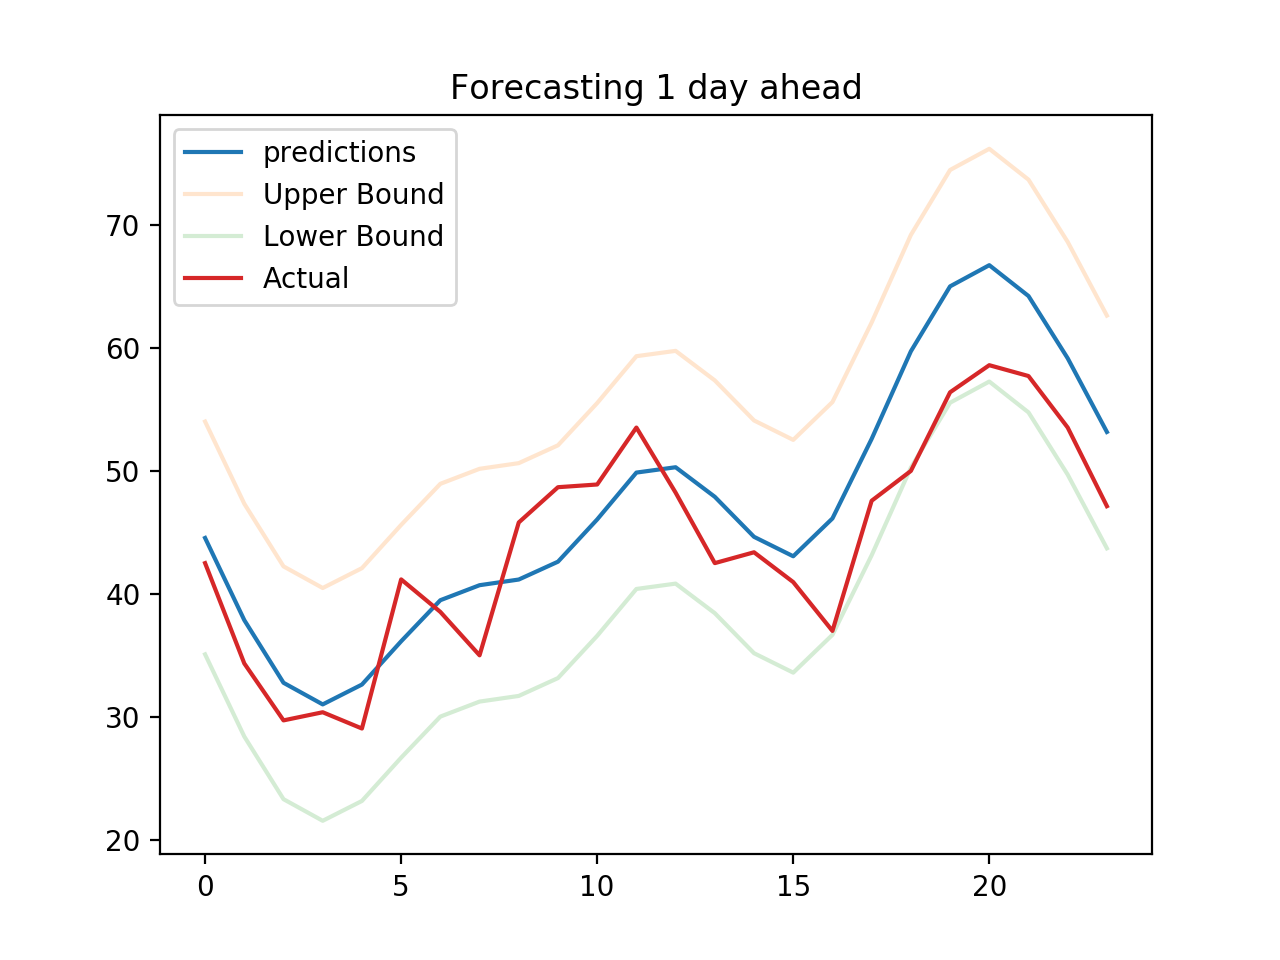

In [34]:
%matplotlib notebook
df = pd.read_sql_query('''select * from predict('electricity_20','MT_020','2014-12-18 01:00:00'\
,'2014-12-19  00:00:00','pindex_e20');''', conn)



plt.figure()
plt.plot( df['prediction'], label = 'predictions')
plt.plot( df['ub'], label = 'Upper Bound', alpha = 0.2)
plt.plot(df['lb'], label = 'Lower Bound', alpha = 0.2)
plt.plot(data_test['MT_020'].values[:len(df['prediction'])], label = 'Actual', alpha = 1.0)
plt.title('Forecasting 1 day ahead')
plt.legend()
plt.show()

### Forecast hourly data for all houses for the next seven days

Now, we will do a more qualitative test by forecasting the next seven days using a rolling window approach. Specifically, we will forecast the next seven days one day at a time for all 20 houses. Between forecasts, we will insert the already predicted data into the database.  We will then compute the error for all predictions vs. the actual readings.



In [ ]:
#initialise prediction array
predictions = np.zeros((len(data_test.columns),24*7))
ub = np.zeros((len(data_test.columns),24*7))
lb = np.zeros((len(data_test.columns),24*7))
actual = data_test.values[:24*7,:]
# specify start time
start_time = pd.Timestamp('2014-12-18 01:00:00')
# predict for seven days
days = 7
for day in range(days):
    print('day: ',day+1)
    # get the final time stamp in the day
    end_time = start_time + pd.Timedelta(hours=23)
    # convert timestamps to string
    start_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
    end_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
    print('starting from %s to  %s '%(start_str,end_str))
    # predict for each house
    for i, column in enumerate(data_test.columns):
        print('predicting column:%s for day %s '%(column,day+1))
        # execute forecast query
        df_30 = pd.read_sql_query('''select * from predict('electricity_20','%s','%s'\
    ,'%s','pindex_e20');'''%(column, start_str, end_str), conn)
        predictions[i,day*24:(day+1)*24] = df_30['prediction']
        ub[i,day*24:(day+1)*24] = df_30['ub']
        lb[i,day*24:(day+1)*24] = df_30['lb']
    # insert the already predicted values into the database
    df_insert = data_test.iloc[day*24:24*(day+1),:]
    bulk_insert(df_insert, 'electricity_20', conn_string)
    # update start_time
    start_time = start_time + pd.Timedelta(hours=24)


day:  1
starting from 2014-12-18 01:00:00 to  2014-12-19 00:00:00 
predicting column:MT_001 for day 1 
predicting column:MT_002 for day 1 
predicting column:MT_003 for day 1 
predicting column:MT_004 for day 1 
predicting column:MT_005 for day 1 
predicting column:MT_006 for day 1 
predicting column:MT_007 for day 1 
predicting column:MT_008 for day 1 
predicting column:MT_009 for day 1 
predicting column:MT_010 for day 1 
predicting column:MT_011 for day 1 
predicting column:MT_012 for day 1 
predicting column:MT_013 for day 1 
predicting column:MT_014 for day 1 
predicting column:MT_015 for day 1 
predicting column:MT_016 for day 1 
predicting column:MT_017 for day 1 
predicting column:MT_018 for day 1 
predicting column:MT_019 for day 1 


Let's calculate the error using the metric Weighted Absolute Percent Error (WAPE) which is calculated as:

$\text{WAPE} = \frac{\sum_i \sum_j |Y_{ij}-\hat{Y}_{ij}|} {\sum_i \sum_j |Y_{ij}|} $

Where:
- $Y_{ij}$ is the actual observation for time series j at time i 
- $\hat{Y}_{ij}$ is the predicted value for time series j at time i 

In [ ]:
Y = actual[:,:]
Y_h = predictions.T[:,:]
wape = np.sum(np.abs(Y-Y_h))/np.sum(np.abs(Y))
print ('Forecasting accuracy (WAPE):',wape)



Now, let's inspect our forecasts visually for all the 20 time series

In [ ]:
%matplotlib notebook
for i in range(20):
    plt.figure()
    plt.title('forecasting the next seven days for %s'%data_test.columns[i])
    plt.plot(predictions[i,:24*7],label= 'predictions')
    plt.plot(ub[i,:24*7],'--',label= 'upper bound', alpha = 0.1)
    plt.plot(lb[i,:24*7],'--',label= 'lower bound')
    plt.plot(actual[:24*7,i],label = 'actual')
    plt.legend()
plt.show()